# Embedding 与 变长输入实战IMDB文本分类

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl,np,pd,sklearn,tf,keras:
    print(module.__name__,module.__version__)

2.0.0
sys.version_info(major=3, minor=6, micro=10, releaselevel='final', serial=0)
matplotlib 3.1.2
numpy 1.18.1
pandas 0.25.3
sklearn 0.22.1
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


In [ ]:
def solve_cudnn_error():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)

solve_cudnn_error()

## 数据读取

In [2]:
# 数据集载入
imdb = keras.datasets.imdb
# 词表大小
vocab_size = 10000
# 从索引多少时构建
index_from = 3
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(
    num_words = vocab_size, index_from = index_from)

### 数据集探索

In [3]:
print(train_data[0], train_labels[0])
print(train_data.shape, train_labels.shape)
print(len(train_data[0]), len(train_data[1]))

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32] 1
(25000,) (25000,)
218 189


In [4]:
print(test_data.shape, test_labels.shape)

(25000,) (25000,)


### 构建词表

In [14]:
# 载入词表
word_index = imdb.get_word_index()
print(len(word_index))
# print(word_index)

88584


In [6]:
# 索引从3开始，所以词表全部偏移3
word_index = {k : (v + 3) for k, v in word_index.items()}

In [7]:
# 添加必要的特殊字符
word_index['<PAD>'] = 0 # padding填充
word_index['<START>'] = 1 # 开始
word_index['<UNK>'] = 2 # 找不到时填补
word_index['<EOS>'] = 3 # 结束

# 构建倒排索引：id到词的索引
reverse_word_index = dict([(value, key) for key, value in word_index.items()])

In [8]:
# 查看train_data具体文本
def decode_review(text_ids):
    return ' '.join(
        [reverse_word_index.get(word_id, '<UNK>') for word_id in text_ids])

decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

### 变长输入处理--Padding和截断

In [9]:
# padding
max_length = 500

train_data = keras.preprocessing.sequence.pad_sequences(
    train_data, value = word_index['<PAD>'], padding = 'post', maxlen = max_length)

test_data = keras.preprocessing.sequence.pad_sequences(
    test_data, value = word_index['<PAD>'], padding = 'post', maxlen = max_length)

print(train_data[0])

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

## 模型构建

Embedding层所做的事情：
1. 构建一个矩阵define matrix：[vocab_size, embedding_dim]
2. 对于每个句子中的索引[1,2,3,4..]，从上述矩阵中查得该索引对应的向量，每个样本变为max_length * embedding_dim 长度的矩阵
3. 对于每个batch，输出数据的长度为batch_size * max_length * embedding_dim

GlobalAveragePooling层：做合并
- 将batch_size * max_length * embedding_dim 变为 batch_size * embedding_dim 的矩阵

In [10]:
embedding_dim = 16 # 每个词Embedding成长度为16的向量
batch_size = 128

model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    keras.layers.GlobalAveragePooling1D(),
    keras.layers.Dense(64, activation = 'relu'),
    keras.layers.Dense(1, activation = 'sigmoid'),
])
model.summary()
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 16)           160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                1088      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 161,153
Trainable params: 161,153
Non-trainable params: 0
_________________________________________________________________


In [11]:
# 训练
history = model.fit(train_data, train_labels, epochs = 30,
                    batch_size = batch_size, validation_split = 0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/30
20000/20000 [==============================] - 4s 193us/sample - loss: 0.6820 - accuracy: 0.6012 - val_loss: 0.6451 - val_accuracy: 0.7424
Epoch 2/30
20000/20000 [==============================] - 3s 133us/sample - loss: 0.5385 - accuracy: 0.8097 - val_loss: 0.4314 - val_accuracy: 0.8536
Epoch 3/30
20000/20000 [==============================] - 3s 136us/sample - loss: 0.3553 - accuracy: 0.8769 - val_loss: 0.3340 - val_accuracy: 0.8754
Epoch 4/30
20000/20000 [==============================] - 3s 132us/sample - loss: 0.2763 - accuracy: 0.8999 - val_loss: 0.3068 - val_accuracy: 0.8790
Epoch 5/30
20000/20000 [==============================] - 3s 130us/sample - loss: 0.2368 - accuracy: 0.9133 - val_loss: 0.2889 - val_accuracy: 0.8858
Epoch 6/30
20000/20000 [==============================] - 3s 130us/sample - loss: 0.2074 - accuracy: 0.9247 - val_loss: 0.2797 - val_accuracy: 0.8918
Epoch 7/30
20000/20000 [===========================

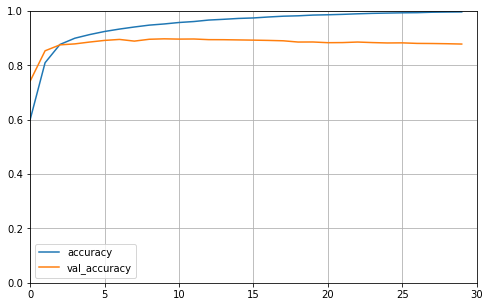

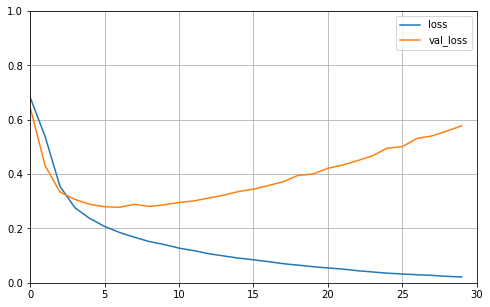

In [12]:
def plot_learning_curves(history, label, epochs, min_value, max_value):
    data = {}
    data[label] = history.history[label]
    data['val_'+label] = history.history['val_'+label]
    pd.DataFrame(data).plot(figsize=(8, 5))
    plt.grid(True)
    plt.axis([0, epochs, min_value, max_value])
    plt.show()
    
plot_learning_curves(history, 'accuracy', 30, 0, 1)
plot_learning_curves(history, 'loss', 30, 0, 1)

In [ ]:
model.evaluate(test_data, test_labels, batch_size = batch_size)